In [95]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [53]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [54]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [55]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [56]:
df['statement'] = df['statement'].fillna('')

In [57]:
def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['statement'] = df['statement'].apply(clean_text)

df.sample(5)

,statement,status
43397,zackdft but i like reading the bullshit,Normal
36109,drrnlvngstn can i have yours clouds have come ...,Normal
13276,i have decided to end it it will be sometime w...,Suicidal
26087,i lost so much in such a short amount of timem...,Suicidal
38630,is it okay stay up all night and and fall asle...,Depression


In [58]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [59]:
df['statement'] = df['statement'].apply(lambda x: remove_stopwords(x))
df.sample(5)

,statement,status
10983,may hard read someas kid exposed lot explicit ...,Suicidal
19692,since find way end going say thisfock neighbor...,Depression
4187,yesterday pd level average today even worse ƒ,Normal
23418,last post really made see cares life goes need...,Depression
21286,feel sick days end eat enough lay bed listen s...,Depression


In [60]:
label_encoder = LabelEncoder()

# Fit and transform the labels in the DataFrame
df['status'] = label_encoder.fit_transform(df['status'])
df.head()

,statement,status
0,oh gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,wrong back dear forward doubt stay restless re...,0
3,ive shifted focus something else im still worried,0
4,im restless restless month boy mean,0


In [61]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stemming function
def stem_text(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed)

# Lemmatization function
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)


In [62]:
# Apply stemming and lemmatization
df['text_stemmed'] = df['statement'].apply(stem_text)
df['text_lemmatized'] = df['statement'].apply(lemmatize_text)

In [63]:
# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()

In [64]:
# Generate TF-IDF and Count Vectorizer features for stemmed text
# tfidf_stemmed = tfidf_vectorizer.fit_transform(df['text_stemmed']).toarray()
# count_stemmed = count_vectorizer.fit_transform(df['text_stemmed']).toarray()

In [65]:
# Generate TF-IDF and Count Vectorizer features for lemmatized text
# tfidf_lemmatized = tfidf_vectorizer.fit_transform(df['text_lemmatized']).toarray()
# count_lemmatized = count_vectorizer.fit_transform(df['text_lemmatized']).toarray()

In [66]:
X_stemmed = df['text_stemmed']
X_lemmatized = df['text_lemmatized']
# Label Encoding

y = df['status']

In [67]:
# Retrieve the mapping
label_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
label_mapping

{'Anxiety': 0,
 'Bipolar': 1,
 'Depression': 2,
 'Normal': 3,
 'Personality disorder': 4,
 'Stress': 5,
 'Suicidal': 6}

In [68]:
X_train_lemmatized, X_test_lemmatized = train_test_split(X_lemmatized, test_size=0.2, random_state=42)

In [69]:
# TF-IDF Vectorization
tfidf_lemmatized = TfidfVectorizer()

X_tfidf_lemmatized = tfidf_vectorizer.fit_transform(X_lemmatized)

In [70]:
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_tfidf_lemmatized, y, test_size=0.2, random_state=42)

In [71]:
mlp_model = MLPClassifier(random_state=42, max_iter=300)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


In [72]:
# Train and evaluate MLP on lemmatized data
mlp_model.fit(X_train_lem, y_train)
y_pred_mlp_lem = mlp_model.predict(X_test_lem)
print("MLP on Lemmatized Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_mlp_lem)))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP on Lemmatized Data:
                       precision    recall  f1-score   support

             Anxiety       0.76      0.77      0.77       779
             Bipolar       0.82      0.73      0.77       580
          Depression       0.65      0.66      0.66      3100
              Normal       0.84      0.88      0.86      3327
Personality disorder       0.76      0.56      0.65       248
              Stress       0.59      0.53      0.56       557
            Suicidal       0.59      0.58      0.58      2018

            accuracy                           0.72     10609
           macro avg       0.72      0.67      0.69     10609
        weighted avg       0.72      0.72      0.72     10609



In [73]:
# Train and evaluate XGBoost on lemmatized data
xgb_model.fit(X_train_lem, y_train)
y_pred_xgb_lem = xgb_model.predict(X_test_lem)
print("XGBoost on Lemmatized Data:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_xgb_lem)))

XGBoost on Lemmatized Data:
                       precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       779
             Bipolar       0.88      0.76      0.82       580
          Depression       0.74      0.73      0.74      3100
              Normal       0.83      0.95      0.88      3327
Personality disorder       0.87      0.55      0.68       248
              Stress       0.70      0.53      0.61       557
            Suicidal       0.68      0.63      0.65      2018

            accuracy                           0.77     10609
           macro avg       0.79      0.71      0.74     10609
        weighted avg       0.77      0.77      0.77     10609



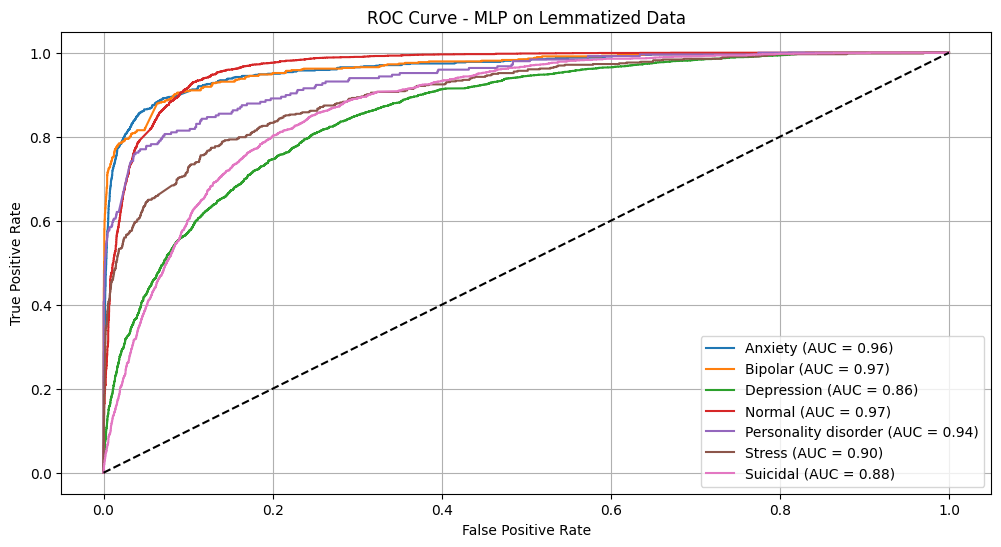

In [76]:
# Get the predicted probabilities for each class
y_pred_prob_mlp = mlp_model.predict_proba(X_test_lem)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_lem)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_mlp[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_mlp[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

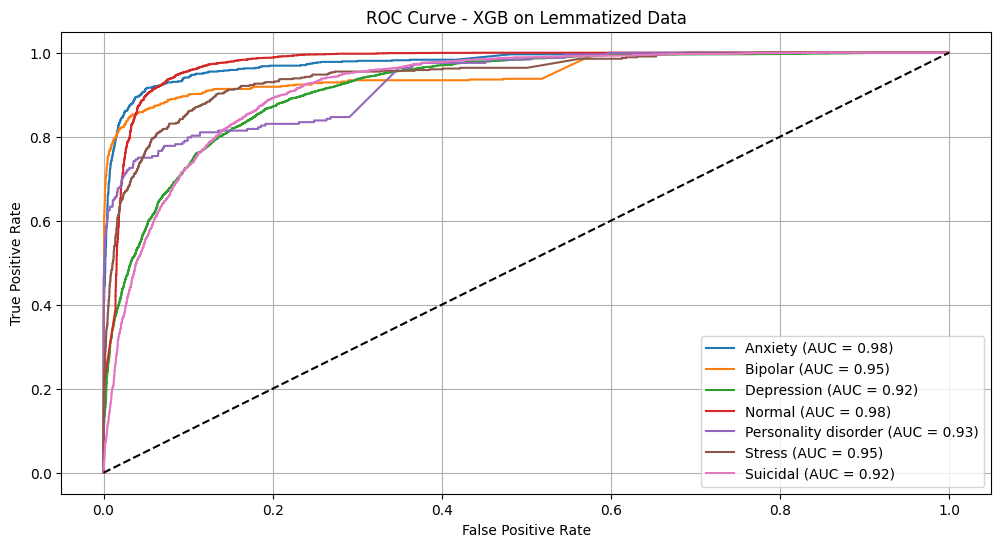

In [79]:
# Plot ROC AUC curve for XGB
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_xgb[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test == i, y_pred_prob_xgb[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

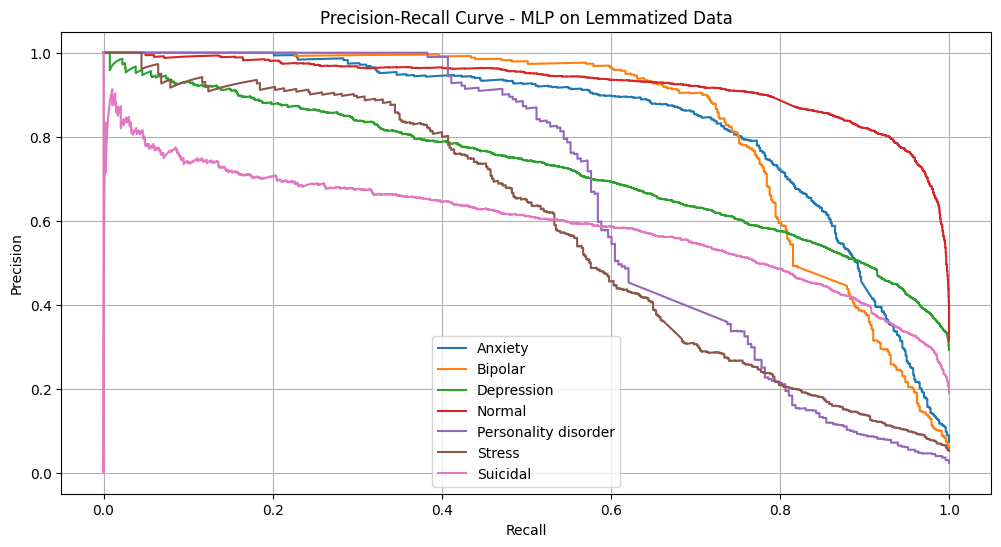

In [80]:
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_mlp[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MLP on Lemmatized Data')
plt.legend(loc='best')
plt.grid()
plt.show()

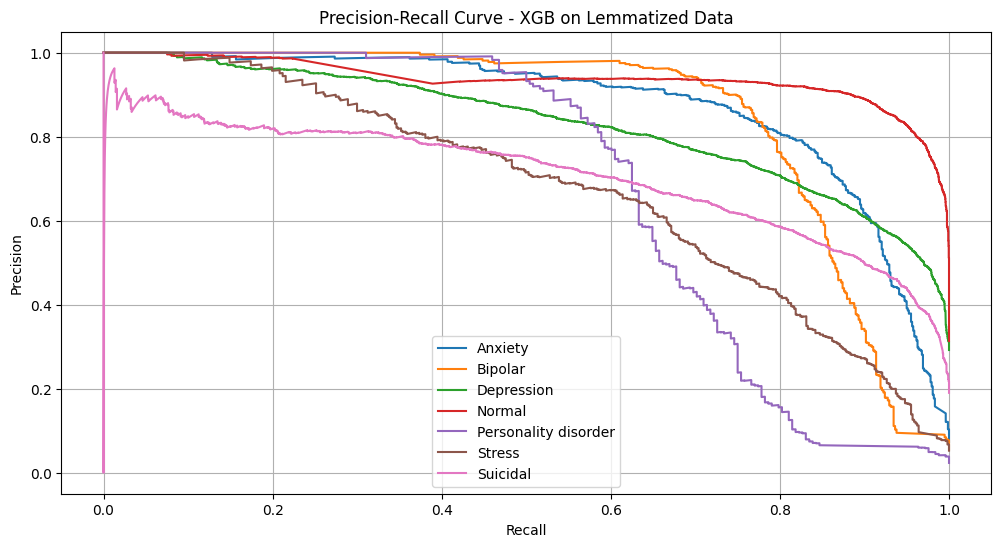

In [81]:
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_prob_xgb[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGB on Lemmatized Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [87]:
# Check original class distribution
print("Original class distribution:")
Counter(label_encoder.inverse_transform(y))

Original class distribution:


Counter({'Normal': 16351,
         'Depression': 15404,
         'Suicidal': 10653,
         'Anxiety': 3888,
         'Bipolar': 2877,
         'Stress': 2669,
         'Personality disorder': 1201})

In [89]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_tfidf_lemmatized, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
Counter(label_encoder.inverse_transform(y_resampled_smote))

Class distribution after SMOTE:


Counter({'Anxiety': 16351,
         'Normal': 16351,
         'Depression': 16351,
         'Suicidal': 16351,
         'Stress': 16351,
         'Bipolar': 16351,
         'Personality disorder': 16351})

In [90]:
# Apply Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled_undersample, y_resampled_undersample = undersampler.fit_resample(X_tfidf_lemmatized, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
Counter(label_encoder.inverse_transform(y_resampled_undersample))

Class distribution after undersampling:


Counter({'Anxiety': 1201,
         'Bipolar': 1201,
         'Depression': 1201,
         'Normal': 1201,
         'Personality disorder': 1201,
         'Stress': 1201,
         'Suicidal': 1201})

In [91]:
X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=42)

In [97]:
# Initialize and train MLP
mlp_model_oversample = MLPClassifier(random_state=42)
mlp_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_mlp_oversample = mlp_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_mlp_oversample)))


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.91      0.91      0.91      3360
             Bipolar       0.92      0.90      0.91      3167
          Depression       0.77      0.67      0.72      3297
              Normal       0.90      0.71      0.79      3331
Personality disorder       0.75      0.99      0.86      3308
              Stress       0.86      0.89      0.87      3182
            Suicidal       0.73      0.75      0.74      3247

            accuracy                           0.83     22892
           macro avg       0.84      0.83      0.83     22892
        weighted avg       0.84      0.83      0.83     22892



In [99]:
xgb_model_oversample = XGBClassifier(random_state=42)
xgb_model_oversample.fit(X_train_oversample, y_train_oversample)

# Make predictions
y_pred_xgb_oversample = xgb_model_oversample.predict(X_test_oversample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_oversample), label_encoder.inverse_transform(y_pred_xgb_oversample)))


XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.90      0.88      0.89      3360
             Bipolar       0.97      0.88      0.92      3167
          Depression       0.74      0.67      0.70      3297
              Normal       0.69      0.92      0.79      3331
Personality disorder       0.94      0.85      0.90      3308
              Stress       0.85      0.84      0.85      3182
            Suicidal       0.73      0.72      0.73      3247

            accuracy                           0.82     22892
           macro avg       0.83      0.82      0.82     22892
        weighted avg       0.83      0.82      0.82     22892



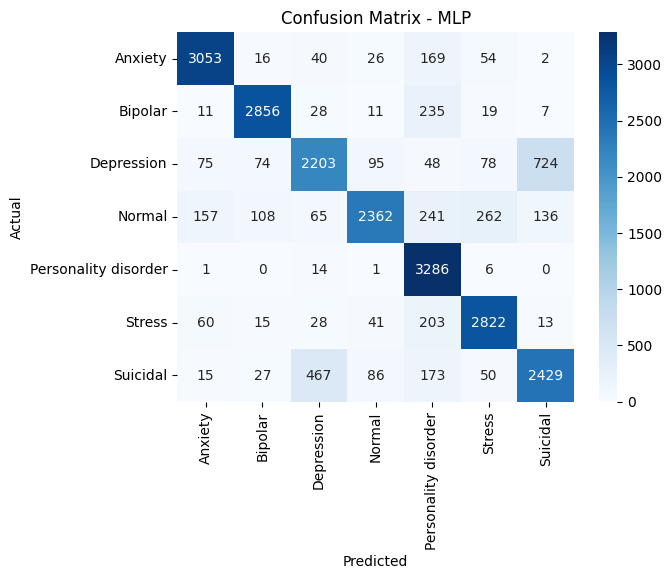

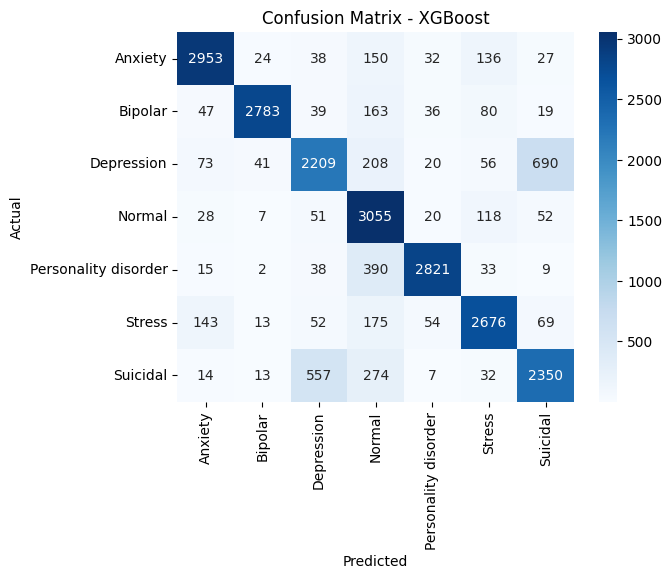

In [100]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_oversample, y_pred_mlp_oversample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_oversample, y_pred_xgb_oversample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


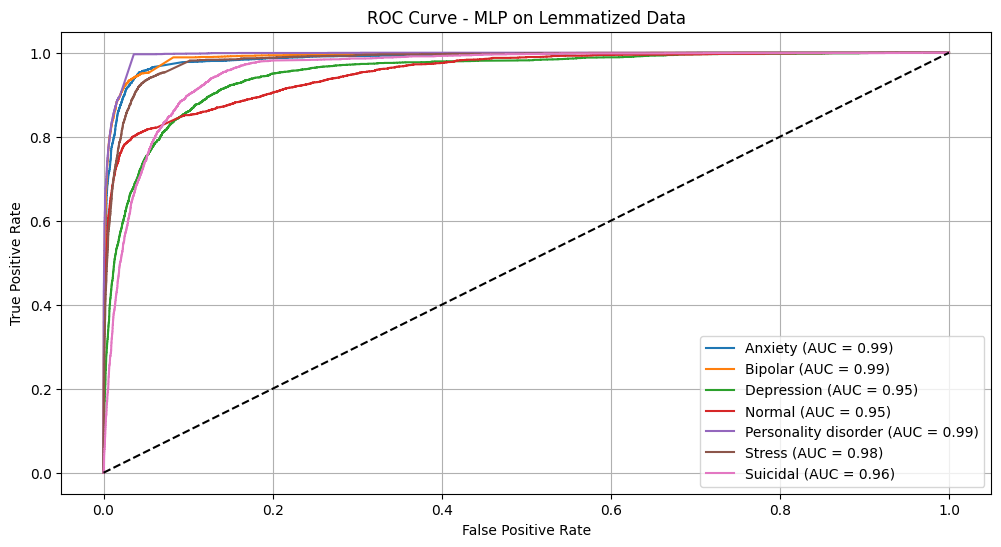

In [103]:
# Get the predicted probabilities for each class
y_pred_prob_mlp_oversample = mlp_model_oversample.predict_proba(X_test_oversample)
y_pred_prob_xgb_oversample = xgb_model_oversample.predict_proba(X_test_oversample)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_mlp_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

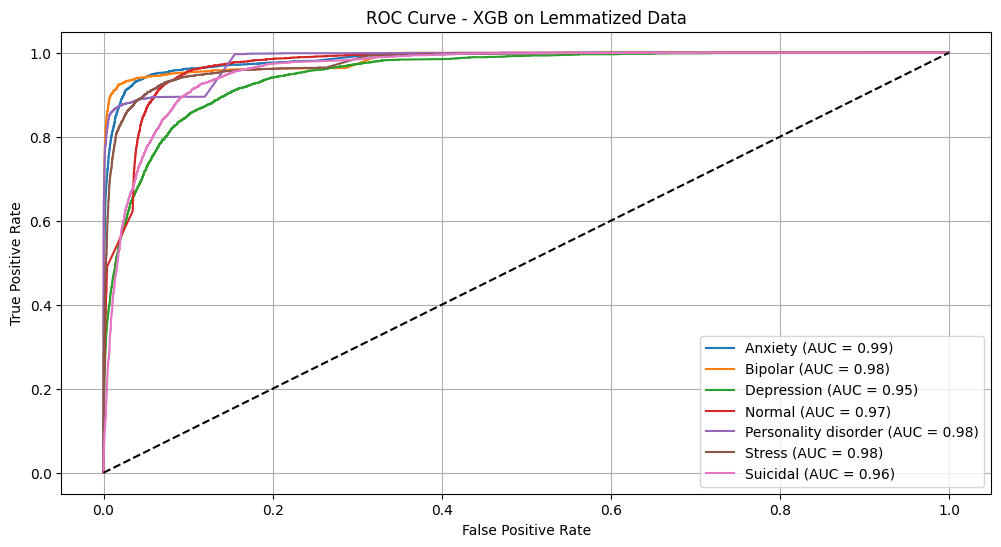

In [106]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_oversample == i, y_pred_prob_xgb_oversample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [107]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_resampled_undersample, y_resampled_undersample, test_size=0.2, random_state=42)

In [108]:
# Initialize and train MLP
mlp_model_undersample = MLPClassifier(random_state=42)
mlp_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_mlp_undersample = mlp_model_undersample.predict(X_test_undersample)

print("MLP Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_mlp_undersample)))


MLP Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       252
             Bipolar       0.81      0.73      0.77       247
          Depression       0.54      0.52      0.53       222
              Normal       0.76      0.56      0.65       247
Personality disorder       0.57      0.82      0.67       241
              Stress       0.58      0.64      0.61       231
            Suicidal       0.66      0.62      0.64       242

            accuracy                           0.66      1682
           macro avg       0.67      0.66      0.66      1682
        weighted avg       0.68      0.66      0.66      1682



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [109]:
xgb_model_undersample = XGBClassifier(random_state=42)
xgb_model_undersample.fit(X_train_undersample, y_train_undersample)

# Make predictions
y_pred_xgb_undersample = xgb_model_undersample.predict(X_test_undersample)

# Evaluate the model
print("XGBoost Model Performance:\n", classification_report(label_encoder.inverse_transform(y_test_undersample), label_encoder.inverse_transform(y_pred_xgb_undersample)))


XGBoost Model Performance:
                       precision    recall  f1-score   support

             Anxiety       0.81      0.75      0.78       252
             Bipolar       0.85      0.70      0.77       247
          Depression       0.65      0.54      0.59       222
              Normal       0.67      0.88      0.76       247
Personality disorder       0.75      0.72      0.73       241
              Stress       0.65      0.71      0.68       231
            Suicidal       0.67      0.70      0.69       242

            accuracy                           0.72      1682
           macro avg       0.72      0.71      0.71      1682
        weighted avg       0.72      0.72      0.72      1682



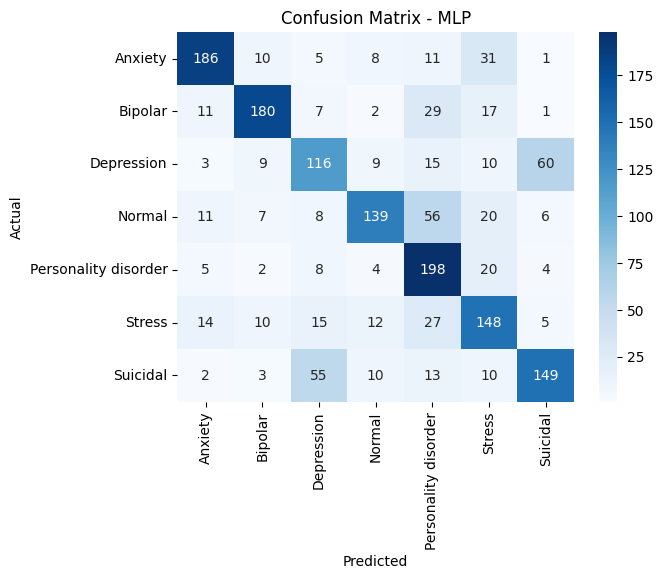

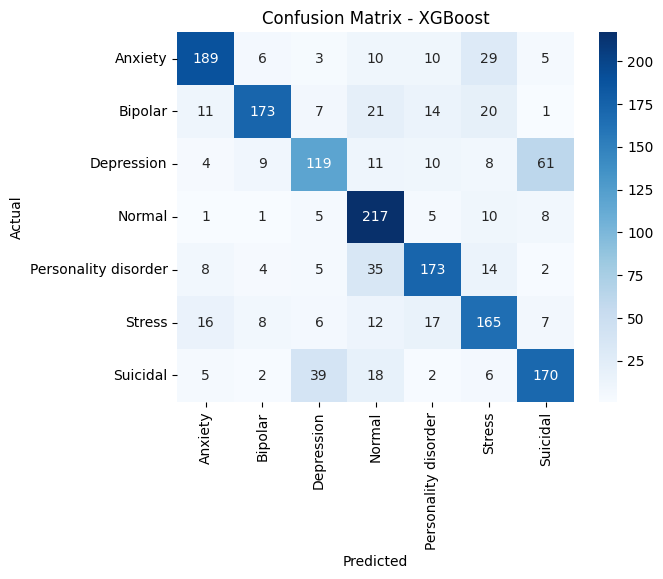

In [110]:
# Confusion matrix for MLP
cm_mlp = confusion_matrix(y_test_undersample, y_pred_mlp_undersample)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_undersample, y_pred_xgb_undersample)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


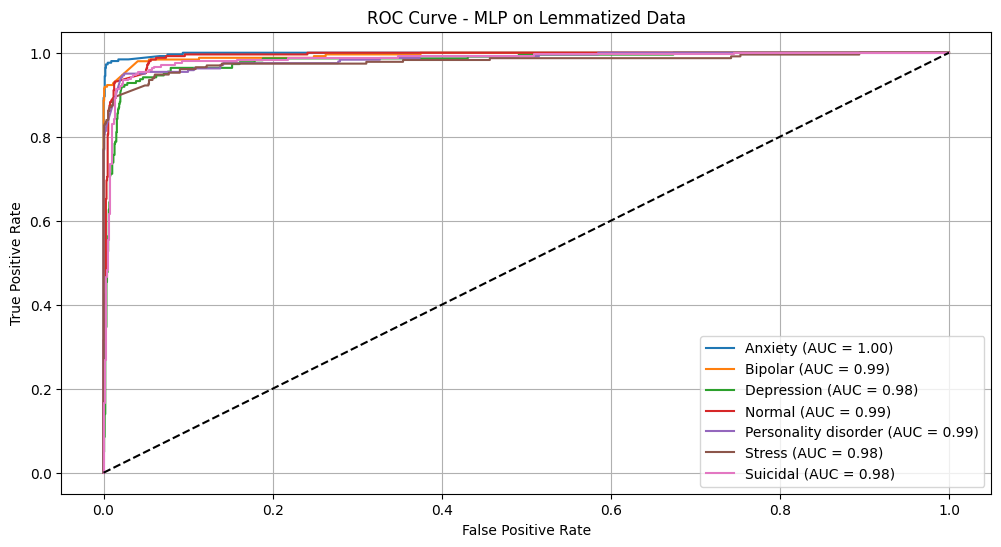

In [111]:
# Get the predicted probabilities for each class
y_pred_prob_mlp_undersample = mlp_model.predict_proba(X_test_undersample)
y_pred_prob_xgb_undersample = xgb_model.predict_proba(X_test_undersample)

# Define classes
classes = label_encoder.inverse_transform(np.unique(y_test_undersample))

# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()

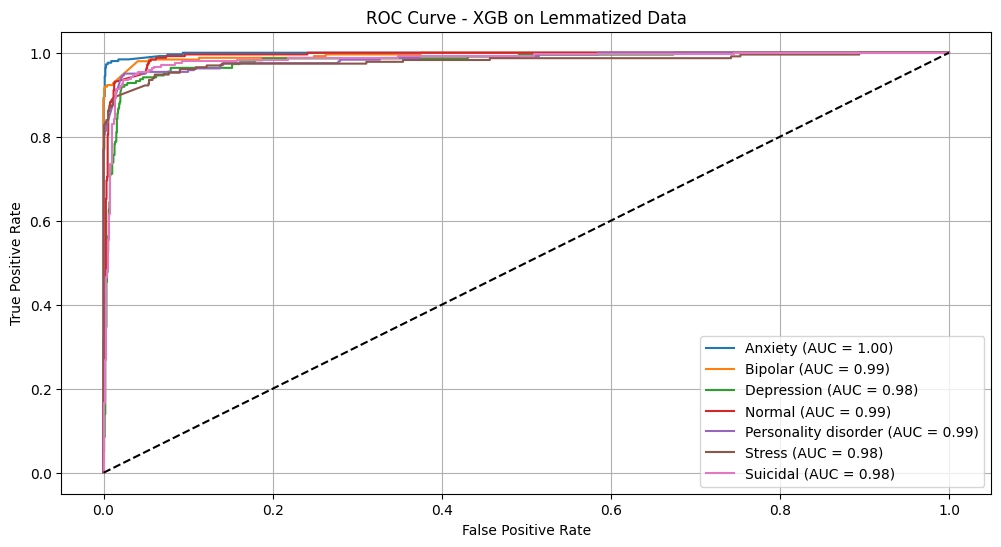

In [112]:
# Plot ROC AUC curve for MLP
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # True labels vs predicted probabilities
    auc = roc_auc_score(y_test_undersample == i, y_pred_prob_mlp_undersample[:, i])  # AUC score
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB on Lemmatized Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()